# Load the data

In [86]:
import os
import numpy as np
import keras
import tensorflow as tf
from keras import layers, models
import matplotlib.pyplot as plt
import zipfile
import shutil


# unzip file
zip_file_path = '/content/SOCOFing.zip'
extracted_path = 'extracted_socofing'

if not os.path.exists(extracted_path):
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extracted_path)

In [87]:
# Define base paths for the dataset
base_path = os.path.join(extracted_path, 'SOCOFing')
altered_base_path = os.path.join(base_path, 'Altered')
real_images_path = os.path.join(base_path, 'Real')

# Print dataset structure and image counts
print("Dataset Structure and Image Counts:")
print("-" * 30)

# Count real images
if os.path.isdir(real_images_path):
    real_image_count = len([name for name in os.listdir(real_images_path) if name.lower().endswith('.bmp')])
    print(f"Real images: {real_image_count}")
else:
    print(f"Directory not found: {real_images_path}")

# Count altered images by difficulty level and in total
altered_total_count = 0
print("Altered images:")
for difficulty_level in ['Altered-Easy', 'Altered-Medium', 'Altered-Hard']:
    level_path = os.path.join(altered_base_path, difficulty_level)
    if os.path.isdir(level_path):
        level_image_count = len([name for name in os.listdir(level_path) if name.lower().endswith('.bmp')])
        print(f"  {difficulty_level}: {level_image_count}")
        altered_total_count += level_image_count
    else:
        print(f"  Directory not found: {level_path}")

print(f"Total Altered images: {altered_total_count}")

Dataset Structure and Image Counts:
------------------------------
Real images: 6000
Altered images:
  Altered-Easy: 17931
  Altered-Medium: 17067
  Altered-Hard: 14272
Total Altered images: 49270


## Data cleaning


In [88]:
# Check for and remove any corrupted images in the dataset.

from PIL import Image

# list to store corrupted image paths
corrupted_images = []

def check_corrupted(directory_path):
    if os.path.isdir(directory_path):
        for filename in os.listdir(directory_path):
            if filename.lower().endswith('.bmp'):
                img_path = os.path.join(directory_path, filename)
                try:
                    with Image.open(img_path) as img:
                        img.verify()
                except Exception:
                    corrupted_images.append(img_path)
    else:
        print(f"Directory not found: {directory_path}")

# Check for corrupted images in Real and Altered directories
real_images_path = os.path.join(base_path, 'Real')
check_corrupted(real_images_path)

altered_base_path = os.path.join(base_path, 'Altered')
for difficulty_level in ['Altered-Easy', 'Altered-Medium', 'Altered-Hard']:
    level_path = os.path.join(altered_base_path, difficulty_level)
    check_corrupted(level_path)
if corrupted_images:
    print("Corrupted images found:")
    for img_path in corrupted_images:
        print(img_path)
else:
    print("No corrupted images found.")

No corrupted images found.


## Creating a subset


In [89]:
## making a smaller subset with  100 images per class for both training and testing (80/20 split).
max_images_per_class = 100

# Get all image file paths for each class
real_image_files = [os.path.join(real_images_path, name) for name in os.listdir(real_images_path) if name.lower().endswith('.bmp')]
altered_image_files = []
for difficulty_level in ['Altered-Easy', 'Altered-Medium', 'Altered-Hard']:
    level_path = os.path.join(altered_base_path, difficulty_level)
    if os.path.isdir(level_path):
        altered_image_files.extend([os.path.join(level_path, name) for name in os.listdir(level_path) if name.lower().endswith('.bmp')])

# Shuffle the file lists
np.random.seed(42)
np.random.shuffle(real_image_files)
np.random.shuffle(altered_image_files)

# Take a subset of the images
real_subset_files = real_image_files[:max_images_per_class]
altered_subset_files = altered_image_files[:max_images_per_class]

# Split the subset files into training and testing sets
validation_split_ratio = 0.2
num_test_per_class = int(max_images_per_class * validation_split_ratio)
num_train_per_class = max_images_per_class - num_test_per_class
real_train_files = real_subset_files[:num_train_per_class]
real_test_files = real_subset_files[num_train_per_class:]
altered_train_files = altered_subset_files[:num_train_per_class]
altered_test_files = altered_subset_files[num_train_per_class:]

print(f"Real train images: {len(real_train_files)}")
print(f"Real test images: {len(real_test_files)}")
print(f"Altered train images: {len(altered_train_files)}")
print(f"Altered test images: {len(altered_test_files)}")

Real train images: 80
Real test images: 20
Altered train images: 80
Altered test images: 20


In [90]:
# Define the base path for the organized dataset
organized_dataset_path = 'organized_fingerprint_dataset'

# Define paths for train and test directories for each class
train_real_dir = os.path.join(organized_dataset_path, 'train', 'Real')
train_altered_dir = os.path.join(organized_dataset_path, 'train', 'Altered')
test_real_dir = os.path.join(organized_dataset_path, 'test', 'Real')
test_altered_dir = os.path.join(organized_dataset_path, 'test', 'Altered')

# Create the directories if they don't exist and clear previous contents
if os.path.exists(organized_dataset_path):
    shutil.rmtree(organized_dataset_path)
os.makedirs(train_real_dir, exist_ok=True)
os.makedirs(train_altered_dir, exist_ok=True)
os.makedirs(test_real_dir, exist_ok=True)
os.makedirs(test_altered_dir, exist_ok=True)


# Function to copy files to a destination directory, handling duplicate basenames
def copy_files(file_list, destination_dir):
    for file_path in file_list:
        try:
            base_name, ext = os.path.splitext(os.path.basename(file_path))
            destination_file_path = os.path.join(destination_dir, os.path.basename(file_path))
            # Check if a duplicate exists
            counter = 1
            while os.path.exists(destination_file_path):
                destination_file_name = f"{base_name}_{counter}{ext}"
                destination_file_path = os.path.join(destination_dir, destination_file_name)
                counter += 1
            shutil.copy(file_path, destination_file_path)
        except FileNotFoundError:
            print(f"Warning: File not found at {file_path}. Skipping.")
        except Exception as e:
            print(f"Error copying file {file_path}: {e}")

copy_files(real_train_files, train_real_dir)
copy_files(real_test_files, test_real_dir)
copy_files(altered_train_files, train_altered_dir)
copy_files(altered_test_files, test_altered_dir)

print(f"Dataset organized in '{organized_dataset_path}'")

# Remove the original extracted directory to keep only the subset
original_extracted_path = '/content/SOCOFing_extracted'
if os.path.exists(original_extracted_path):
    try:
        shutil.rmtree(original_extracted_path)
        print(f"Removed original extracted dataset at '{original_extracted_path}'")
    except Exception as e:
        print(f"Error removing original extracted dataset: {e}")
else:
    print(f"Original extracted dataset not found at '{original_extracted_path}', no need to remove.")

Dataset organized in 'organized_fingerprint_dataset'
Original extracted dataset not found at '/content/SOCOFing_extracted', no need to remove.


## Data Loader

In [91]:
import tensorflow as tf

# Define image size and batch size
image_size = (224, 224)
batch_size = 10

# Define dataset paths based on the organized structure
organized_dataset_path = 'organized_fingerprint_dataset'
train_dir = os.path.join(organized_dataset_path, 'train')
test_dir = os.path.join(organized_dataset_path, 'test')

# Create training dataset from the 'train' directory
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='binary',
    image_size=image_size,
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=True,
    seed=42
)

# Create validation dataset from the test directory
val_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='binary',
    image_size=image_size,
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=False,  # Do not shuffle validation data
    seed=42
)

class_names = train_ds.class_names
print(f"Class names: {class_names}")

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 160 files belonging to 2 classes.
Found 40 files belonging to 2 classes.
Class names: ['Altered', 'Real']


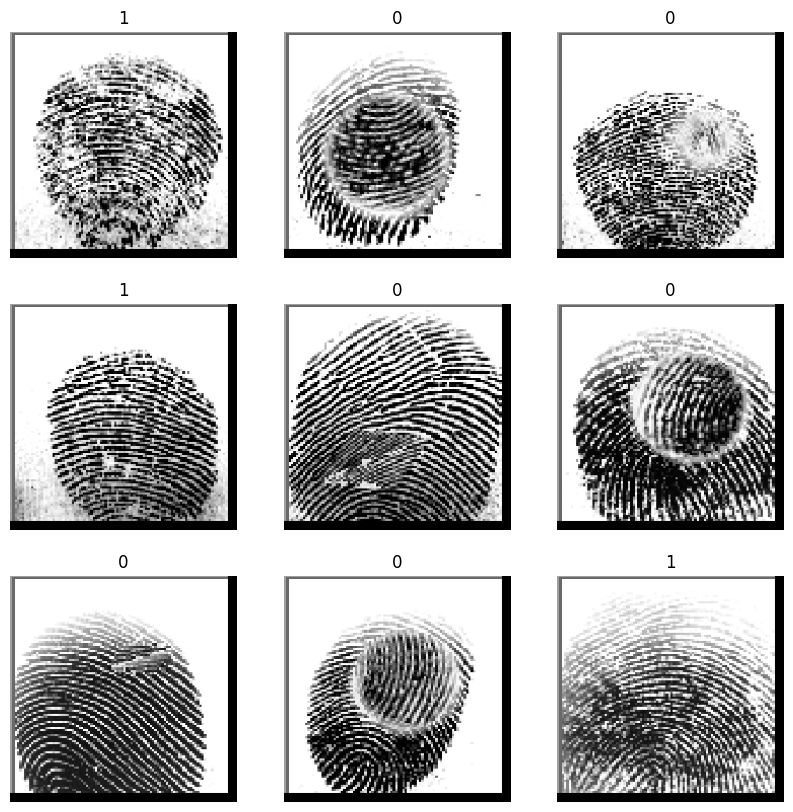

In [92]:
# visualize one batch of images and labels from the training dataset
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

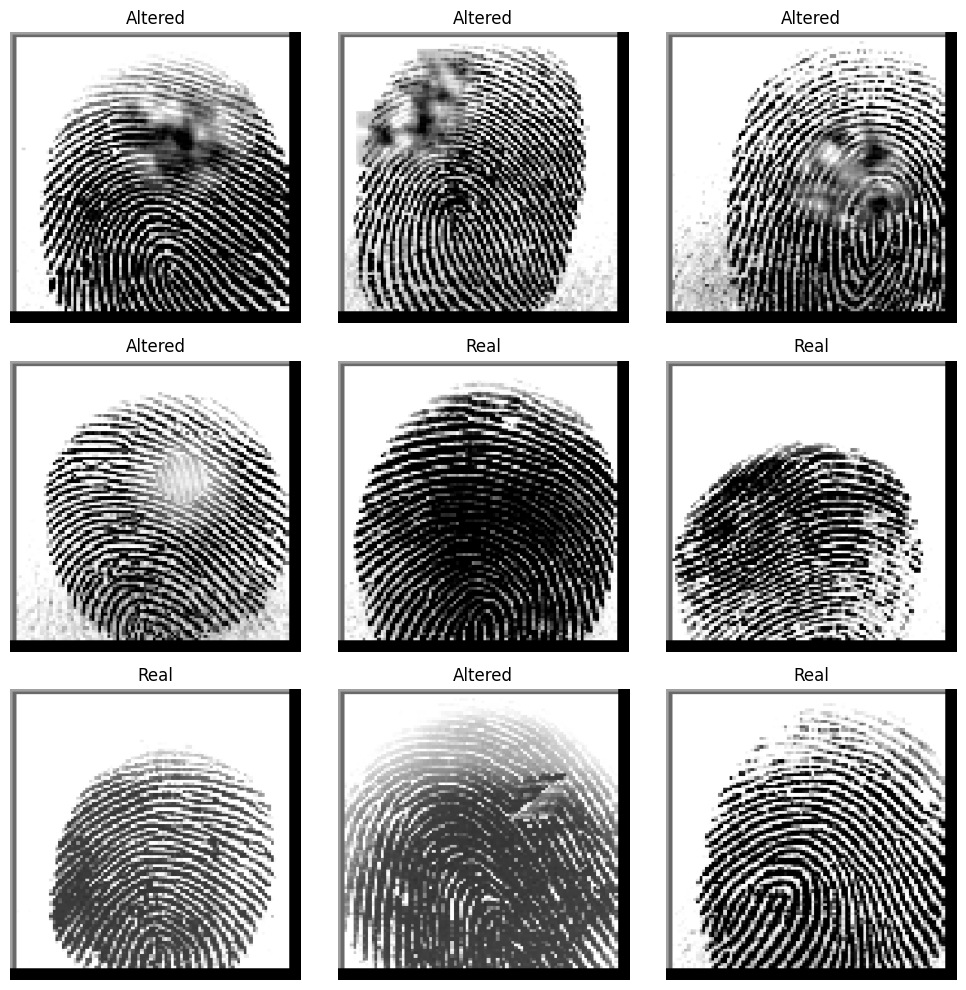

In [93]:
# more visualization not using binary
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9): # Display the first 9 images
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i].numpy().astype("uint8")[0]])
        plt.axis("off")
    plt.tight_layout()
    plt.show()

## Data Augmentation


In [94]:
# Data Augmentation Layers
data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]

def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

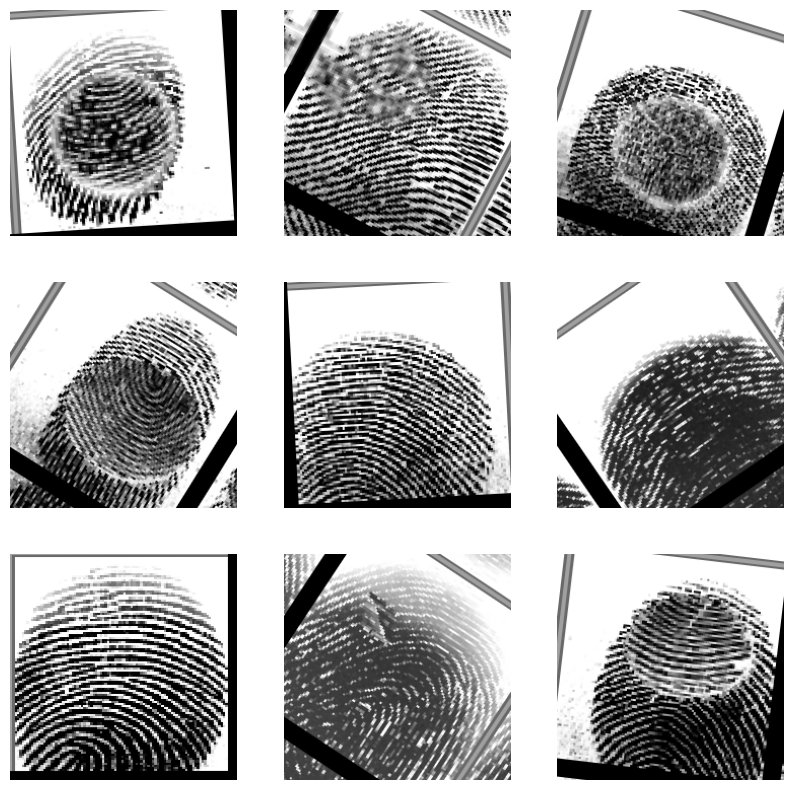

In [95]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    augmented_images = data_augmentation(images)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[i].numpy().astype("uint8"))
        plt.axis("off")

In [96]:
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

In [97]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        units = 1
    else:
        units = num_classes

    x = layers.Dropout(0.25)(x)
    outputs = layers.Dense(units, activation=None)(x)
    return keras.Model(inputs, outputs)

model = make_model(input_shape=image_size + (3,), num_classes=2)

In [98]:
epochs = 8

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy(name="acc")],
)

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/8
16/16 ━━━━━━━━━━━━━━━━━━━━ 177s 10s/step - acc: 0.6511 - loss: 0.6538 - val_acc: 0.5000 - val_loss: 0.6933
Epoch 2/8
16/16 ━━━━━━━━━━━━━━━━━━━━ 178s 11s/step - acc: 0.7189 - loss: 0.6266 - val_acc: 0.5000 - val_loss: 0.6938
Epoch 3/8
16/16 ━━━━━━━━━━━━━━━━━━━━ 209s 12s/step - acc: 0.7606 - loss: 0.5435 - val_acc: 0.5000 - val_loss: 0.6952
Epoch 4/8
16/16 ━━━━━━━━━━━━━━━━━━━━ 183s 10s/step - acc: 0.7978 - loss: 0.4332 - val_acc: 0.5000 - val_loss: 0.6984
Epoch 5/8
16/16 ━━━━━━━━━━━━━━━━━━━━ 156s 10s/step - acc: 0.7738 - loss: 0.3966 - val_acc: 0.5000 - val_loss: 0.7065
Epoch 6/8
16/16 ━━━━━━━━━━━━━━━━━━━━ 155s 10s/step - acc: 0.8522 - loss: 0.3542 - val_acc: 0.5000 - val_loss: 0.7173
Epoch 7/8
16/16 ━━━━━━━━━━━━━━━━━━━━ 208s 10s/step - acc: 0.8417 - loss: 0.3453 - val_acc: 0.5000 - val_loss: 0.7359
Epoch 8/8
16/16 ━━━━━━━━━━━━━━━━━━━━ 163s 10s/step - acc: 0.8464 - loss: 0.3160 - val_acc: 0.5000 - val_loss: 0.7591


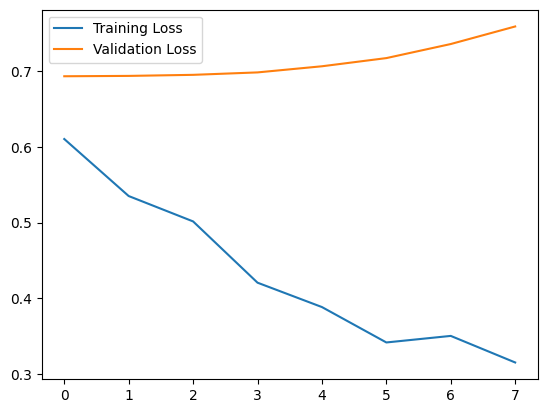

In [99]:
plt.plot(range(len(history.history["loss"])),history.history["loss"],label="Training Loss")
plt.plot(range(len(history.history["val_loss"])),history.history["val_loss"],label="Validation Loss")
plt.legend()

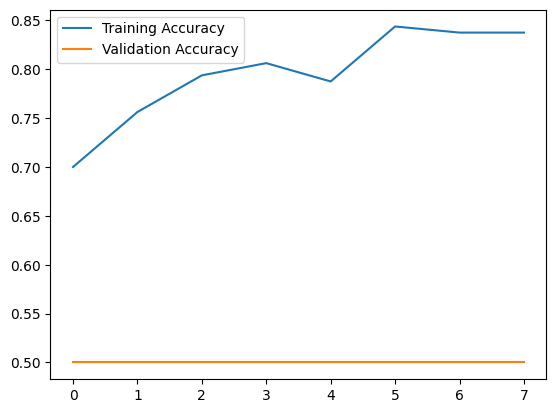

In [100]:
plt.plot(range(len(history.history["acc"])),history.history["acc"],label="Training Accuracy")
plt.plot(range(len(history.history["val_acc"])),history.history["val_acc"],label="Validation Accuracy")
plt.legend()

# Training Baseline Model

## Train Base Model (ResNet50)

In [137]:
from tensorflow import data as tf_data

# Define dataset paths
organized_dataset_path = 'organized_fingerprint_dataset'
train_dir = os.path.join(organized_dataset_path, 'train')
test_dir = os.path.join(organized_dataset_path, 'test')

# Define image size and batch size
image_size = (224, 224)
batch_size = 10

# Load training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='binary',
    image_size=image_size,
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=True,
    seed=42 # seed for reproducibility
)

# Load validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels='inferred', # Infer labels from directory names
    label_mode='binary',
    image_size=image_size,
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=False, # Do not shuffle validation data
    seed=42
)

class_names = train_ds.class_names
print(f"Class names: {class_names}")


# Prefetch datasets
AUTOTUNE = tf_data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

print("Datasets loaded and prefetched.")

Found 160 files belonging to 2 classes.
Found 40 files belonging to 2 classes.
Class names: ['Altered', 'Real']
Datasets loaded and prefetched.


In [138]:
# Building the transfer model
from keras.applications import ResNet50

# Load the pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=image_size + (3,))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Create the new model on top of the base model
inputs = keras.Input(shape=image_size + (3,))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.25)(x)  # dropout for regularization
outputs = layers.Dense(1, activation=None)(x)
model = keras.Model(inputs, outputs)

In [139]:
# Compiling and training the model

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=3e-4),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy(name="acc")],
)
callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
history = model.fit(
    train_ds,
    callbacks=callbacks,
    validation_data=val_ds,
    epochs = 10
)

Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 50s 3s/step - acc: 0.5087 - loss: 0.7531 - val_acc: 0.4250 - val_loss: 0.7020
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - acc: 0.5274 - loss: 0.7302 - val_acc: 0.4750 - val_loss: 0.6359
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - acc: 0.5657 - loss: 0.6881 - val_acc: 0.6250 - val_loss: 0.5862
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - acc: 0.6644 - loss: 0.6421 - val_acc: 0.6500 - val_loss: 0.5501
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - acc: 0.5630 - loss: 0.6155 - val_acc: 0.6750 - val_loss: 0.5183
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - acc: 0.7132 - loss: 0.5844 - val_acc: 0.7500 - val_loss: 0.4914
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - acc: 0.6387 - loss: 0.5735 - val_acc: 0.7750 - val_loss: 0.4713
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step - acc: 0.7313 - loss: 0.5047 - val_acc: 0.7750 - val_loss: 0.4582
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - acc: 0.6599 - loss: 

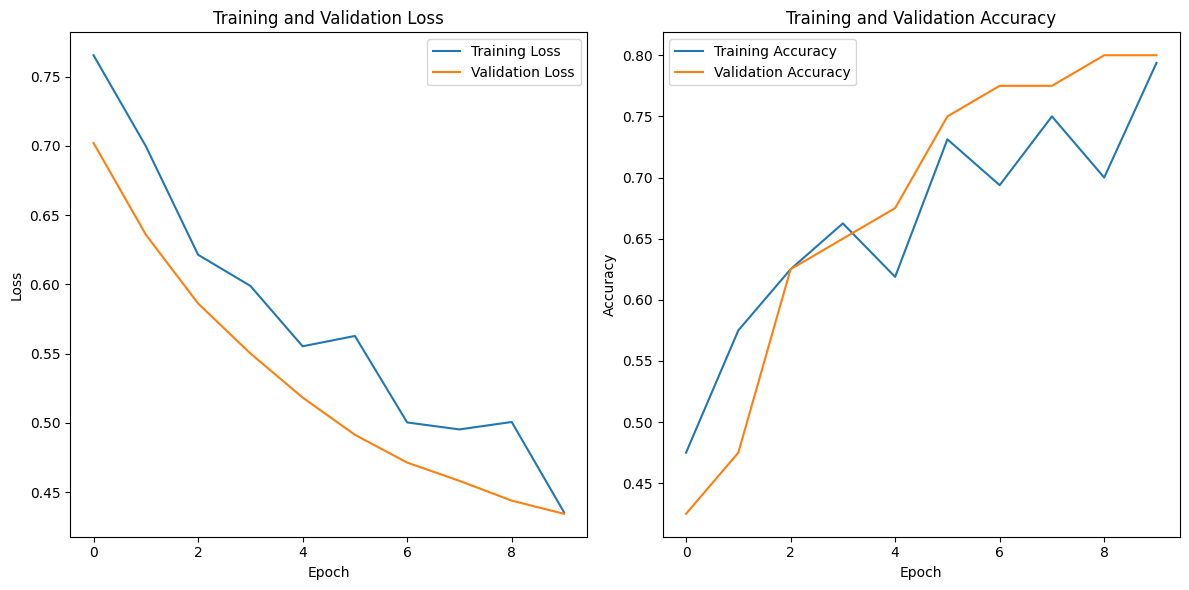

In [143]:
# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['acc'], label='Training Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [144]:
model.save('baseline_resnet50.keras')

In [147]:
# Evaluate the ResNet50 base model on the validation dataset
resnet50_eval_results = baseline_model.evaluate(val_ds)

# Print the validation loss and accuracy
print(f"ResNet50 (Base) Validation Loss: {resnet50_eval_results[0]:.4f}")
print(f"ResNet50 (Base) Validation Accuracy: {resnet50_eval_results[1]:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - acc: 0.8767 - loss: 0.4044
ResNet50 (Base) Validation Loss: 0.4213
ResNet50 (Base) Validation Accuracy: 0.8000


### Analysis:

*   The training and validation datasets were successfully loaded, with the training set containing 160 images and the validation set containing 40 images, distributed across 2 classes: 'Altered' and 'Real'.
*   The transfer learning model was built using a frozen ResNet50 base, with only the newly added classification layers being trainable.
*   The model was compiled using the Adam optimizer, Binary Crossentropy loss, and Binary Accuracy as the metric.
*   The model was trained for 10 epochs, and the training history (loss and accuracy for both training and validation sets) was recorded.

Overall, the baseline model (ResNet50) showed consistent improvement, reaching a training accuracy of about 75% and a validation accuracy of about 80%. The model also showed a steady decrease in loss. Based on the learning curves, further steps could include fine-tuning the ResNet50 model (unfreezing some layers) with a lower learning rate to potentially improve performance.


## Train Base Model Augmentation

Data augmentation applied and datasets prefetched.


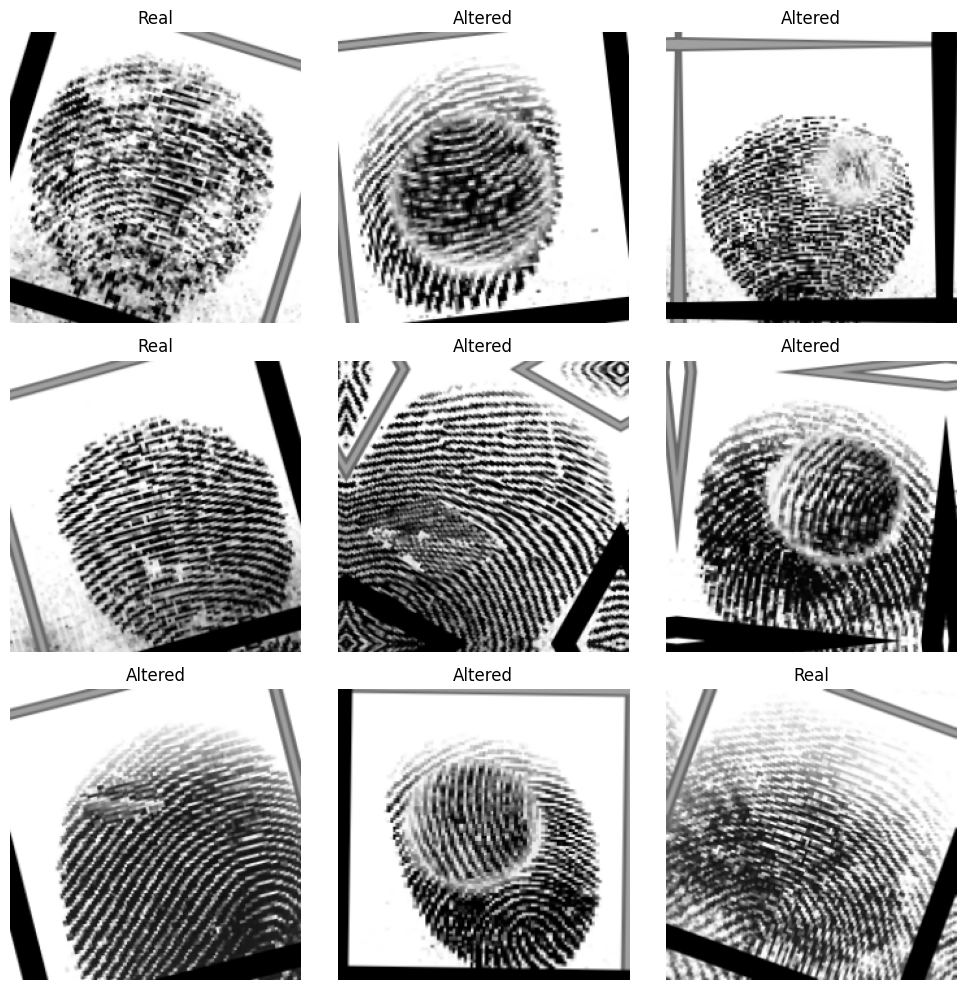

In [108]:
# Define Data Augmentation Layers
data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
]

# Function to apply data augmentation layers
def apply_data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

# Apply data augmentation to the training dataset
train_ds = train_ds.map(
    lambda img, label: (apply_data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)

# Prefetch datasets
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

print("Data augmentation applied and datasets prefetched.")

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i].numpy().astype("uint8")[0]])
        plt.axis("off")
plt.tight_layout()
plt.show()

In [109]:
# Load the pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=image_size + (3,))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Create the new model on top of the base model
inputs = keras.Input(shape=image_size + (3,))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.25)(x)
outputs = layers.Dense(1, activation=None)(x)
model = keras.Model(inputs, outputs)

In [110]:
# Compiling and training the model

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=3e-4),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy(name="acc")],
)
callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
history = model.fit(
    train_ds,
    callbacks=callbacks,
    validation_data=val_ds,
    epochs = 10,
)

Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 50s 3s/step - acc: 0.5656 - loss: 0.8168 - val_acc: 0.5750 - val_loss: 0.6409
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - acc: 0.5061 - loss: 0.8020 - val_acc: 0.6750 - val_loss: 0.6035
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - acc: 0.5445 - loss: 0.7239 - val_acc: 0.7000 - val_loss: 0.5671
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - acc: 0.6588 - loss: 0.6332 - val_acc: 0.7500 - val_loss: 0.5445
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - acc: 0.6584 - loss: 0.5757 - val_acc: 0.8250 - val_loss: 0.5271
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - acc: 0.5896 - loss: 0.5894 - val_acc: 0.8250 - val_loss: 0.5279
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - acc: 0.7128 - loss: 0.5440 - val_acc: 0.8250 - val_loss: 0.5104
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - acc: 0.6094 - loss: 0.6436 - val_acc: 0.8500 - val_loss: 0.5027
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - acc: 0.6129 - loss: 

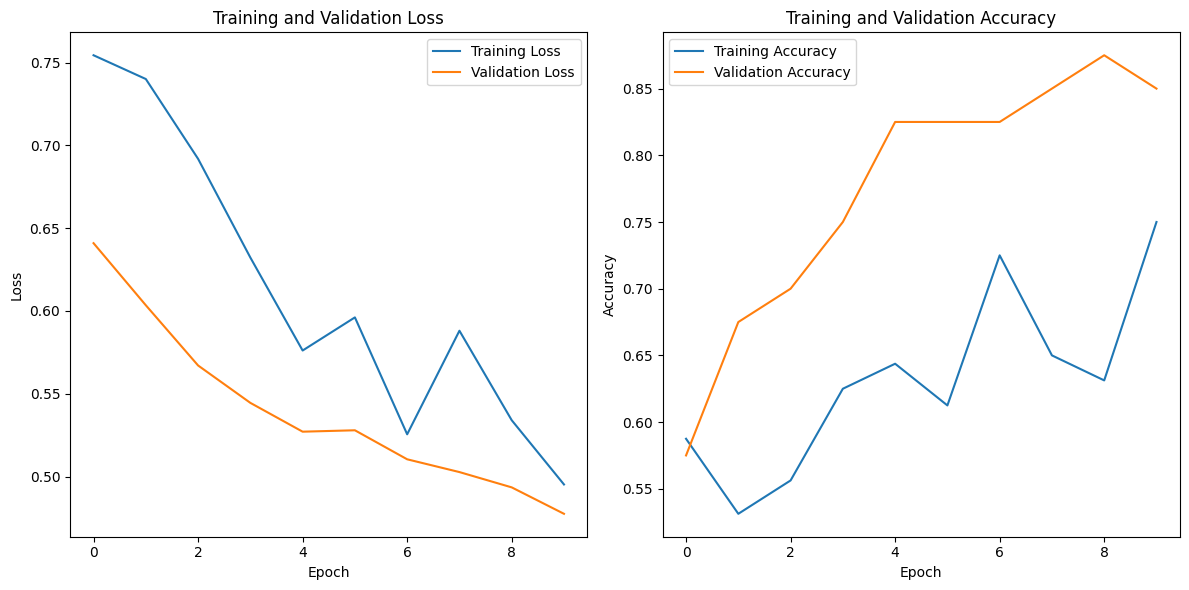

In [111]:
# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['acc'], label='Training Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [112]:
model.save('augmented_resnet50.keras')

In [114]:
# Evaluate the ResNet50 base model on the validation dataset
augmented_resnet50_model = keras.models.load_model('augmented_resnet50.keras')
resnet50_aug_eval_results = augmented_resnet50_model.evaluate(val_ds)

print(f"ResNet50 (Augmented) Validation Loss: {resnet50_aug_eval_results[0]:.4f}")
print(f"ResNet50 (Augmented) Validation Accuracy: {resnet50_aug_eval_results[1]:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - acc: 0.8567 - loss: 0.5496
ResNet50 (Augmented) Validation Loss: 0.4775
ResNet50 (Augmented) Validation Accuracy: 0.8500


### Analysis:


* The accuracy for the training and validation sets both steadily increased then slightly decreased at epoch 10. The training accuracy for the model peaked at about 71% then decreased back down to 70%. The validation accuracy peaked at about 88% then went back down to 85%. The loss for both sets steadily decreased after each epoch.

## Compare Augmentation

In [116]:
import keras
from sklearn.metrics import roc_curve, auc

In [117]:
baseline_model = keras.models.load_model("baseline_resnet50.keras")
augmented_model = keras.models.load_model("augmented_resnet50.keras")

In [118]:
%%writefile data_utils.py
import os
import numpy as np
import keras
from keras import layers
from tensorflow import data as tf_data
import tensorflow as tf
import zipfile
import shutil
from PIL import Image

def unzip_dataset(zip_file_path, extracted_path):
    if not os.path.exists(extracted_path):
        print(f"Extracting {zip_file_path} to {extracted_path}")
        with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
            zip_ref.extractall(extracted_path)
    else:
        print(f"Dataset already extracted to {extracted_path}")

def check_corrupted_images(directory_path):
    corrupted_images = []
    if os.path.isdir(directory_path):
        for filename in os.listdir(directory_path):
            if filename.lower().endswith(('.bmp', '.jpg', '.jpeg', '.png')):
                img_path = os.path.join(directory_path, filename)
                try:
                    with Image.open(img_path) as img:
                        img.verify()
                except Exception:
                    corrupted_images.append(img_path)
    else:
        print(f"Directory not found: {directory_path}")
    return corrupted_images

def organize_dataset(real_train_files, real_test_files, altered_train_files, altered_test_files, organized_dataset_path='organized_fingerprint_dataset'):
    train_real_dir = os.path.join(organized_dataset_path, 'train', 'Real')
    train_altered_dir = os.path.join(organized_dataset_path, 'train', 'Altered')
    test_real_dir = os.path.join(organized_dataset_path, 'test', 'Real')
    test_altered_dir = os.path.join(organized_dataset_path, 'test', 'Altered')

    if os.path.exists(organized_dataset_path):
        shutil.rmtree(organized_dataset_path)
    os.makedirs(train_real_dir, exist_ok=True)
    os.makedirs(train_altered_dir, exist_ok=True)
    os.makedirs(test_real_dir, exist_ok=True)
    os.makedirs(test_altered_dir, exist_ok=True)

    def copy_files(file_list, destination_dir):
        for file_path in file_list:
            try:
                base_name, ext = os.path.splitext(os.path.basename(file_path))
                destination_file_path = os.path.join(destination_dir, os.path.basename(file_path))
                counter = 1
                while os.path.exists(destination_file_path):
                    destination_file_name = f"{base_name}_{counter}{ext}"
                    destination_file_path = os.path.join(destination_dir, destination_file_name)
                    counter += 1
                shutil.copy(file_path, destination_file_path)
            except FileNotFoundError:
                print(f"Warning: File not found at {file_path}. Skipping.")
            except Exception as e:
                print(f"Error copying file {file_path}: {e}")
    copy_files(real_train_files, train_real_dir)
    copy_files(real_test_files, test_real_dir)
    copy_files(altered_train_files, train_altered_dir)
    copy_files(altered_test_files, test_altered_dir)
    print(f"Dataset organized in '{organized_dataset_path}'")
    return organized_dataset_path

def create_image_datasets(train_dir, test_dir, image_size=(224, 224), batch_size=10, seed=42, shuffle_train=True, shuffle_test=False):
    AUTOTUNE = tf_data.AUTOTUNE
    train_ds = tf.keras.utils.image_dataset_from_directory(
        train_dir,
        labels='inferred',
        label_mode='binary',
        image_size=image_size,
        interpolation='nearest',
        batch_size=batch_size,
        shuffle=shuffle_train,
        seed=seed
    )
    val_ds = tf.keras.utils.image_dataset_from_directory(
        test_dir,
        labels='inferred',
        label_mode='binary',
        image_size=image_size,
        interpolation='nearest',
        batch_size=batch_size,
        shuffle=shuffle_test,
        seed=seed
    )
    class_names = train_ds.class_names
    print(f"Class names: {class_names}")
    train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
    val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
    return train_ds, val_ds, class_names

def get_data_augmentation_layers():
    return [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ]
def apply_data_augmentation(images, data_augmentation_layers):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images
def augment_dataset(dataset, data_augmentation_layers):
    dataset = dataset.map(
        lambda img, label: (apply_data_augmentation(img, data_augmentation_layers), label),
        num_parallel_calls=tf_data.AUTOTUNE,
    )
    return dataset

Overwriting data_utils.py


In [119]:
import importlib
import data_utils
import os
import tensorflow as tf
import numpy as np

importlib.reload(data_utils)

organized_dataset_path = 'organized_fingerprint_dataset'
test_dir = os.path.join(organized_dataset_path, 'test')

image_size = (224, 224)
batch_size = 10

_, test_ds, class_names = data_utils.create_image_datasets(
    test_dir,
    test_dir,
    image_size=image_size,
    batch_size=batch_size,
    shuffle_train=False,
    shuffle_test=False
)

AUTOTUNE = tf.data.AUTOTUNE
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)
true_labels = np.concatenate([y.numpy() for x, y in test_ds], axis=0)
true_labels = true_labels.astype(np.int64)

print("Test dataset loaded and prepared.")
print(f"Number of test samples: {len(true_labels)}")

Found 40 files belonging to 2 classes.
Found 40 files belonging to 2 classes.
Class names: ['Altered', 'Real']
Test dataset loaded and prepared.
Number of test samples: 40


In [120]:
# Generate predictions for the baseline model
baseline_predictions = baseline_model.predict(test_ds)

# Generate predictions for the augmented model
augmented_predictions = augmented_model.predict(test_ds)

baseline_probabilities = tf.sigmoid(baseline_predictions).numpy()
augmented_probabilities = tf.sigmoid(augmented_predictions).numpy()

4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step


In [121]:
from sklearn.metrics import roc_curve, auc

# Calculate ROC curve and AUC for the baseline model
fpr_baseline, tpr_baseline, _ = roc_curve(true_labels, baseline_probabilities)
roc_auc_baseline = auc(fpr_baseline, tpr_baseline)

# Calculate ROC curve and AUC for the augmented model
fpr_augmented, tpr_augmented, _ = roc_curve(true_labels, augmented_probabilities)
roc_auc_augmented = auc(fpr_augmented, tpr_augmented)

# Print AUC values
print(f"AUC for Baseline Model: {roc_auc_baseline:.4f}")
print(f"AUC for Augmented Model: {roc_auc_augmented:.4f}")

AUC for Baseline Model: 0.9125
AUC for Augmented Model: 0.9250


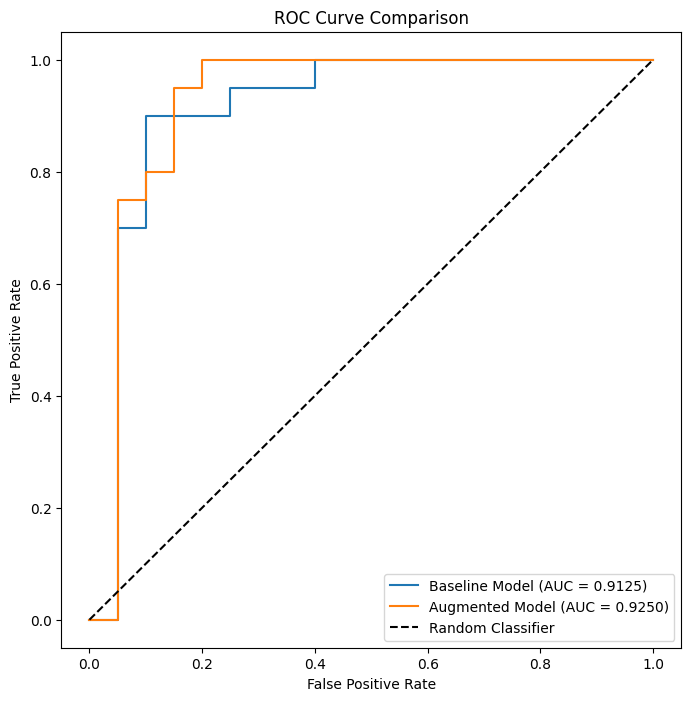

In [122]:
plt.figure(figsize=(8, 8))

# Plot the ROC curve for the baseline model
plt.plot(fpr_baseline, tpr_baseline, label=f'Baseline Model (AUC = {roc_auc_baseline:.4f})')
# Plot the ROC curve for the augmented model
plt.plot(fpr_augmented, tpr_augmented, label=f'Augmented Model (AUC = {roc_auc_augmented:.4f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()

### Analysis:

*   The baseline ResNet50 model achieved an AUC of 0.9125 on the test dataset.
*   The augmented ResNet50 model achieved an AUC of 0.9250 on the test dataset.
*   The ROC curve for both models performed nearly the same , but the augmented model achieved slightly better performance.

 Learning curves for both models showed a significant gap between training and validation performance, suggesting potential overfitting on the training data or limitations in the frozen base models' ability to generalize to the validation set for this specific task. Since the AUC score and ROC curves were nearly the same for both models is is difficult to say which model is more robust, but with perhaps better data augmentation and fine tuning the models may perform differently.

# Training Different Transfer Models

Training the models without augmentation since there is very little difference withor without.

In [148]:
# Define dataset paths based on the organized structure
organized_dataset_path = 'organized_fingerprint_dataset'
train_dir = os.path.join(organized_dataset_path, 'train')
test_dir = os.path.join(organized_dataset_path, 'test')

# Define image size and batch size
image_size = (224, 224)
batch_size = 10

# Create training dataset from the 'train' directory
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='binary',
    image_size=image_size,
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=True,
    seed=42
)

# Create validation dataset from the test directory
val_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='binary',
    image_size=image_size,
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=False,  # Do not shuffle validation data
    seed=42
)

class_names = train_ds.class_names
print(f"Class names: {class_names}")

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

print("Datasets loaded and prefetched without data augmentation.")

Found 160 files belonging to 2 classes.
Found 40 files belonging to 2 classes.
Class names: ['Altered', 'Real']
Datasets loaded and prefetched without data augmentation.


## Train MobileNetV2 Model

In [149]:
from keras.applications import MobileNetV2

# Load the MobileNetV2 model
base_model_mobilenetv2 = MobileNetV2(weights='imagenet', include_top=False, input_shape=image_size + (3,))

# Freeze the base model layers
for layer in base_model_mobilenetv2.layers:
    layer.trainable = False

# Create the new model on top of the base model
inputs = keras.Input(shape=image_size + (3,))
x = base_model_mobilenetv2(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.25)(x)
outputs = layers.Dense(1, activation=None)(x)
mobilenetv2_model = keras.Model(inputs, outputs)


# Compiling and training the model
mobilenetv2_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=3e-4),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy(name="acc")],
)
callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
history_mobilenetv2 = mobilenetv2_model.fit(
    train_ds,
    callbacks=callbacks,
    validation_data=val_ds,
    epochs = 10,
)

Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - acc: 0.5035 - loss: 0.8461 - val_acc: 0.4750 - val_loss: 0.6835
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 473ms/step - acc: 0.4701 - loss: 0.7728 - val_acc: 0.5750 - val_loss: 0.6479
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 544ms/step - acc: 0.5433 - loss: 0.7201 - val_acc: 0.5250 - val_loss: 0.6244
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 549ms/step - acc: 0.6264 - loss: 0.7115 - val_acc: 0.5750 - val_loss: 0.6030
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 458ms/step - acc: 0.6438 - loss: 0.6753 - val_acc: 0.5250 - val_loss: 0.5863
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 458ms/step - acc: 0.6354 - loss: 0.6763 - val_acc: 0.5500 - val_loss: 0.5768
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 513ms/step - acc: 0.6646 - loss: 0.6245 - val_acc: 0.5500 - val_loss: 0.5640
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 543ms/step - acc: 0.7085 - loss: 0.5513 - val_acc: 0.5500 - val_loss: 0.5527
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 448ms/step -

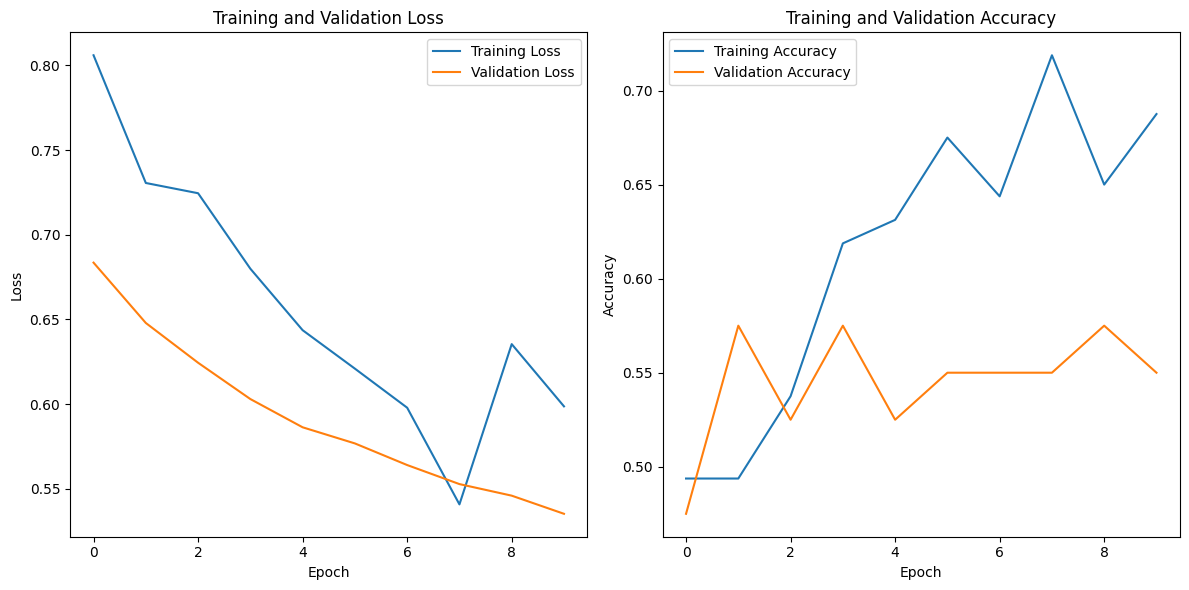

In [150]:
# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_mobilenetv2.history['loss'], label='Training Loss')
plt.plot(history_mobilenetv2.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history_mobilenetv2.history['acc'], label='Training Accuracy')
plt.plot(history_mobilenetv2.history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [151]:
mobilenetv2_model.save('base_mobilenetv2.keras')

In [152]:
# Evaluate the MobileNetV2 model on the validation dataset
mobilenetv2_eval_results = mobilenetv2_model.evaluate(val_ds)

# Print the validation loss and accuracy
print(f"MobileNetV2 Validation Loss: {mobilenetv2_eval_results[0]:.4f}")
print(f"MobileNetV2 Validation Accuracy: {mobilenetv2_eval_results[1]:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 330ms/step - acc: 0.6567 - loss: 0.5285
MobileNetV2 Validation Loss: 0.5352
MobileNetV2 Validation Accuracy: 0.5500


Analysis:

The model training accuracy was increasing and peaked at epoch 8 with about 71% accuracy, but then decreased down to 67% accuracy. The validation accuracy was highest at about 58% at 3 different epochs, but ultimately dwindled down to 55%. Both the training and validation loss steadily decreased.
The MobileNetV2 model compared to the base ResNet50 performed about the same for training accuracy but significantly worse for the validation accuracy.

## Train EfficientNetB0 Model

In [153]:
from keras.applications import EfficientNetB0

# Load the pre-trained EfficientNetB0 model
base_model_efficientnetb0 = EfficientNetB0(weights='imagenet', include_top=False, input_shape=image_size + (3,))

# Freeze the base model layers
for layer in base_model_efficientnetb0.layers:
    layer.trainable = False

# Create the new model on top of the base model
inputs = keras.Input(shape=image_size + (3,))
x = base_model_efficientnetb0(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.25)(x)
outputs = layers.Dense(1, activation=None)(x)
efficientnetb0_model = keras.Model(inputs, outputs)

# Compile the model
efficientnetb0_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=3e-4),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy(name="acc")],
)
callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]

# Train the compiled model
history_efficientnetb0 = efficientnetb0_model.fit(
    train_ds,
    callbacks=callbacks,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - acc: 0.4938 - loss: 0.7305 - val_acc: 0.5000 - val_loss: 0.6979
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 17s 842ms/step - acc: 0.5650 - loss: 0.6804 - val_acc: 0.5250 - val_loss: 0.6733
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 850ms/step - acc: 0.5978 - loss: 0.6350 - val_acc: 0.5500 - val_loss: 0.6498
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 857ms/step - acc: 0.6158 - loss: 0.6543 - val_acc: 0.5500 - val_loss: 0.6285
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 859ms/step - acc: 0.7081 - loss: 0.6098 - val_acc: 0.5750 - val_loss: 0.6115
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 848ms/step - acc: 0.6114 - loss: 0.5930 - val_acc: 0.5500 - val_loss: 0.5935
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 21s 892ms/step - acc: 0.6846 - loss: 0.5828 - val_acc: 0.5500 - val_loss: 0.5783
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 21s 957ms/step - acc: 0.6500 - loss: 0.5734 - val_acc: 0.6500 - val_loss: 0.5646
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 854ms/ste

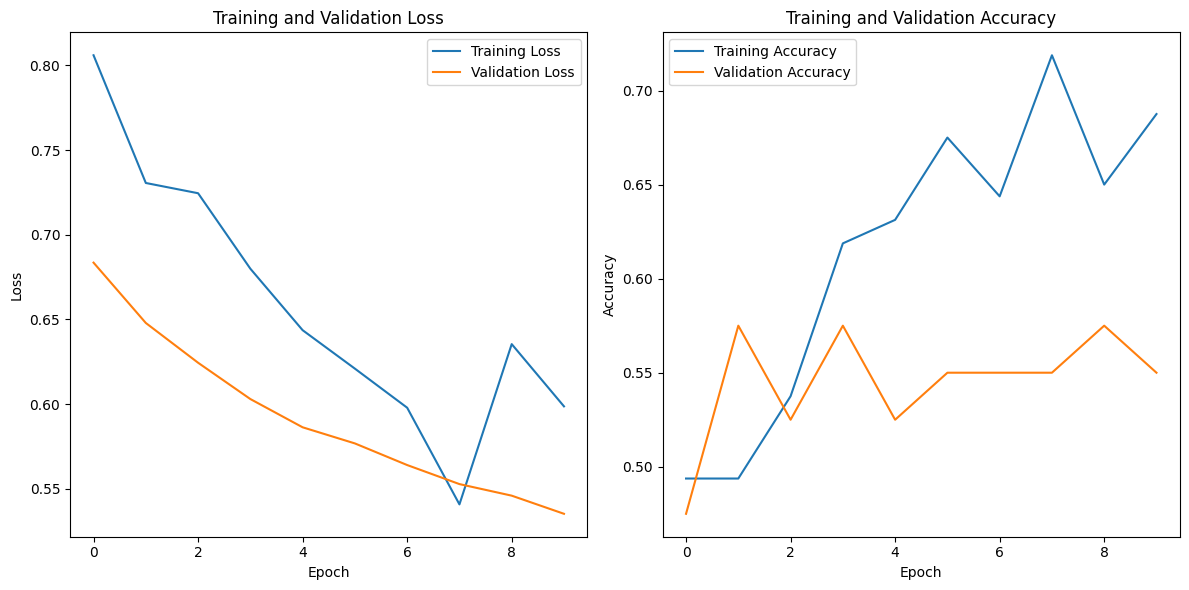

In [154]:
# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_mobilenetv2.history['loss'], label='Training Loss')
plt.plot(history_mobilenetv2.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history_mobilenetv2.history['acc'], label='Training Accuracy')
plt.plot(history_mobilenetv2.history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [155]:
efficientnetb0_model.save('base_model_efficientnetb0.keras')

In [156]:
# Evaluate the EfficientNetB0 model on the validation dataset
efficientnetb0_eval_results = efficientnetb0_model.evaluate(val_ds)
# Print the validation loss and accuracy
print(f"EfficientNetB0 Validation Loss: {efficientnetb0_eval_results[0]:.4f}")
print(f"EfficientNetB0 Validation Accuracy: {efficientnetb0_eval_results[1]:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 567ms/step - acc: 0.7467 - loss: 0.5401
EfficientNetB0 Validation Loss: 0.5410
EfficientNetB0 Validation Accuracy: 0.6500


Analysis:

This model had increased accuracy for both training and validation after each epoch. The training accuracy was about 71% and the validation accuracy was 65%. Both sets also showed steady decrease in loss after the 10 epochs.
Compared to the base ResNet50 this model performed about the same for training accuracy but worse for the validation accuracy.

## Compare All Models (No Augmentation)



In [160]:
# Load the three trained models
baseline_resnet50_model = keras.models.load_model("baseline_resnet50.keras")
mobilenetv2_model = keras.models.load_model("base_mobilenetv2.keras")
efficientnetb0_model = keras.models.load_model("base_model_efficientnetb0.keras")

print("All three models loaded successfully.")

# Generate predictions for each model on the test dataset
baseline_resnet50_predictions = baseline_resnet50_model.predict(test_ds)
mobilenetv2_predictions = mobilenetv2_model.predict(test_ds)
efficientnetb0_predictions = efficientnetb0_model.predict(test_ds)

# Apply sigmoid activation to convert logits to probabilities
baseline_resnet50_probabilities = tf.sigmoid(baseline_resnet50_predictions).numpy()
mobilenetv2_probabilities = tf.sigmoid(mobilenetv2_predictions).numpy()
efficientnetb0_probabilities = tf.sigmoid(efficientnetb0_predictions).numpy()

print("Predictions generated for all models.")

All three models loaded successfully.
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 337ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 573ms/step
Predictions generated for all models.


AUC for Baseline ResNet50 Model: 0.8875
AUC for MobileNetV2 Model: 0.8125
AUC for EfficientNetB0 Model: 0.8175


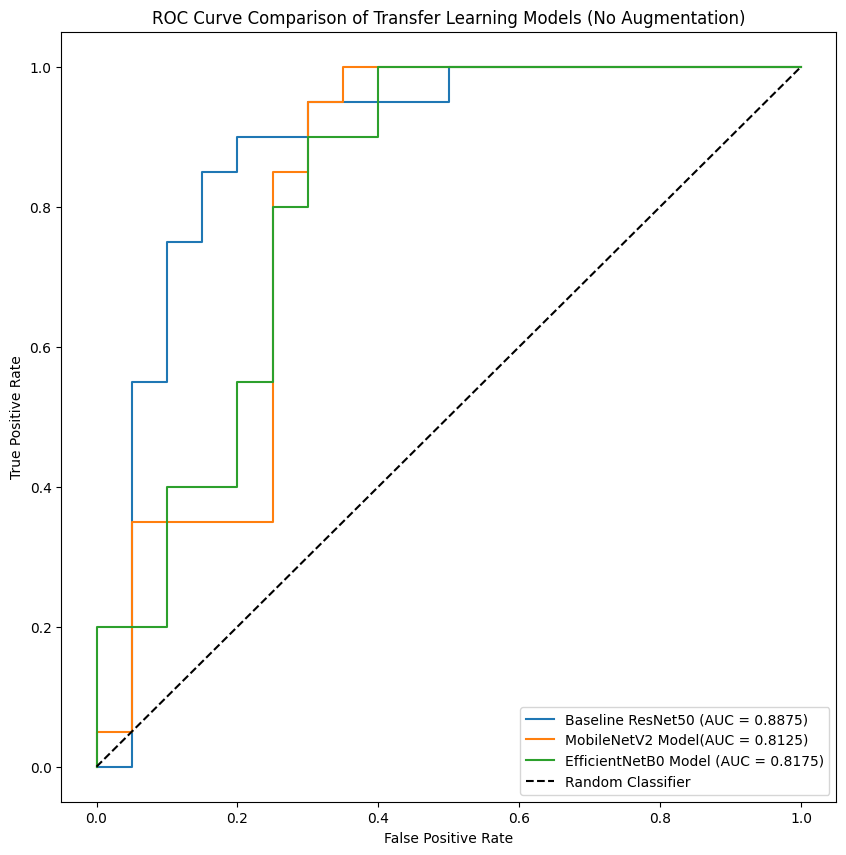

In [161]:
# Calculate ROC curve and AUC for models
fpr_baseline_resnet50, tpr_baseline_resnet50, _ = roc_curve(true_labels, baseline_resnet50_probabilities)
roc_auc_baseline_resnet50 = auc(fpr_baseline_resnet50, tpr_baseline_resnet50)
fpr_mobilenetv2, tpr_mobilenetv2, _ = roc_curve(true_labels, mobilenetv2_probabilities)
roc_auc_mobilenetv2 = auc(fpr_mobilenetv2, tpr_mobilenetv2)
fpr_efficientnetb0, tpr_efficientnetb0, _ = roc_curve(true_labels, efficientnetb0_probabilities)
roc_auc_efficientnetb0 = auc(fpr_efficientnetb0, tpr_efficientnetb0)

# Print AUC values
print(f"AUC for Baseline ResNet50 Model: {roc_auc_baseline_resnet50:.4f}")
print(f"AUC for MobileNetV2 Model: {roc_auc_mobilenetv2:.4f}")
print(f"AUC for EfficientNetB0 Model: {roc_auc_efficientnetb0:.4f}")

plt.figure(figsize=(10, 10))

# Plot the ROC curves for all models
plt.plot(fpr_baseline_resnet50, tpr_baseline_resnet50, label=f'Baseline ResNet50 (AUC = {roc_auc_baseline_resnet50:.4f})')
plt.plot(fpr_mobilenetv2, tpr_mobilenetv2, label=f'MobileNetV2 Model(AUC = {roc_auc_mobilenetv2:.4f})')
plt.plot(fpr_efficientnetb0, tpr_efficientnetb0, label=f'EfficientNetB0 Model (AUC = {roc_auc_efficientnetb0:.4f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison of Transfer Learning Models (No Augmentation)')
plt.legend()
plt.show()

## Summary:

*   The test dataset used for evaluation contained 40 samples.
*   The AUC values for the models were:
    *   Baseline ResNet50: 0.8875
    *   Non-augmented MobileNetV2: 0.8125
    *   Non-augmented EfficientNetB0: 0.8175




The ResNet50 architecture, even without data augmentation, demonstrated superior performance compared to the MobileNetV2 and EfficientNetB0 models on this specific small subset of the dataset.
This could be attributed to differences in the architectures and their ability to learn relevant features from the limited training data, or the effectiveness of the pre-trained ImageNet weights for this task on each architecture.
The non-augmented EfficientNetB0 performed reasonably well, suggesting its potential, but still lagged behind the ResNet50 in this comparison.
The non-augmented MobileNetV2 had the lowest AUC and accuracy scores, indicating it struggled more to generalize to the test set in this non-augmented scenario. Overall, the results suggest that ResNet50 offers the most balanced and reliable performance for this dataset.


### Next Steps

*   The ResNet50 architecture demonstrated superior performance without data augmentation compared to MobileNetV2 and EfficientNetB0 on this small dataset subset, potentially due to architectural differences or the effectiveness of pre-trained weights.
*   Future steps to improve these models could include comparing these non-augmented models with their augmented counterparts to assess the impact of data augmentation on each architecture's performance and fine-tuning the top layers of these models with a lower learning rate.